abc


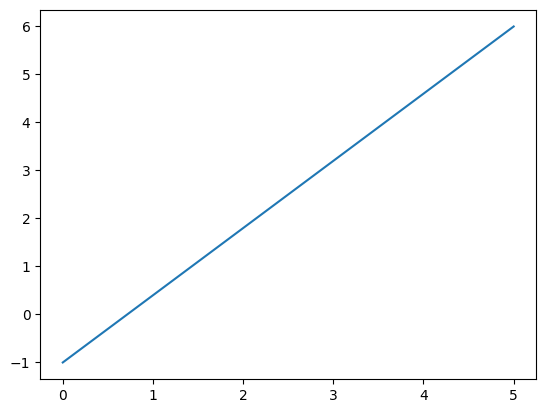

(array([0.        , 0.10204082, 0.20408163, 0.30612245, 0.40816327,
        0.51020408, 0.6122449 , 0.71428571, 0.81632653, 0.91836735,
        1.02040816, 1.12244898, 1.2244898 , 1.32653061, 1.42857143,
        1.53061224, 1.63265306, 1.73469388, 1.83673469, 1.93877551,
        2.04081633, 2.14285714, 2.24489796, 2.34693878, 2.44897959,
        2.55102041, 2.65306122, 2.75510204, 2.85714286, 2.95918367,
        3.06122449, 3.16326531, 3.26530612, 3.36734694, 3.46938776,
        3.57142857, 3.67346939, 3.7755102 , 3.87755102, 3.97959184,
        4.08163265, 4.18367347, 4.28571429, 4.3877551 , 4.48979592,
        4.59183673, 4.69387755, 4.79591837, 4.89795918, 5.        ]),
 array([-1.        , -0.85714286, -0.71428571, -0.57142857, -0.42857143,
        -0.28571429, -0.14285714,  0.        ,  0.14285714,  0.28571429,
         0.42857143,  0.57142857,  0.71428571,  0.85714286,  1.        ,
         1.14285714,  1.28571429,  1.42857143,  1.57142857,  1.71428571,
         1.85714286,  2.  

In [40]:
import functools

import numpy as np
import matplotlib.pyplot as plt

def plot_scatter(plot_type="matplotlib"):
    def plot_scatter_decorator(func):
        @functools.wraps(func)
        def plot_scatter_wrapper(*args, **kwargs):
            # x, y = np.linspace(0,5), np.linspace(0,10)
            print(plot_type)
            x, y = func(*args, **kwargs)
            plt.plot(x,y)
            plt.show()
            return x, y
        return(plot_scatter_wrapper)
    return plot_scatter_decorator

@plot_scatter("abc")
def testplot(x_min=0, x_max=5, y_min=-1, y_max=6):
    x, y = np.linspace(x_min, x_max), np.linspace(y_min, y_max)
    return x, y

testplot()

In [12]:
import base64
from pathlib import Path

from ase.io import read
from dash import Dash, dcc, html, Input, Output, callback, dash_table
import dash_bootstrap_components as dbc
from IPython.display import update_display, display, DisplayHandle
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from weas_widget import WeasWidget

from mlip_testing import analysis
from mlip_testing.analysis import homonuclear_diatomics
from mlip_testing.analysis.utils import get_config

In [2]:
config = get_config(
    "/Users/elliottkasoar/Documents/PSDI/mlip-testing/mlip_testing/analysis/configs/homonuclear_diatomics_config.yml"
)

test = "homonuclear_diatomics"
name = config[test]["name"]

module = getattr(analysis, config[test]["module"])
mlips = config[test]["mlips"]

get_structs = getattr(module, config[test]["structs"])
structs = get_structs()

In [3]:
input_results = {}
metric_results = {}

metrics = config[test]["score"]["metrics"]

for metric in metrics:
    inputs_name = metrics[metric]["inputs"]
    get_inputs = getattr(
        module, metrics[metric][inputs_name]["calc"]
    )
    input_results[metric] = get_inputs(mlips)

    get_metric = getattr(module, metrics[metric]["calc"])
    metric_results[metric] = get_metric(mlips, input_results[metric])

get_score = getattr(module, config[test]["score"]["calc"])
score = get_score(mlips, metric_results)

In [4]:
score_columns = ("MLIP", f"{name} Score")
score_data = [
    {"MLIP": mlip, f"{name} Score": score[mlip]} for mlip in mlips
]

metrics_columns = ("MLIP",) + tuple(metric_results.keys())

metrics_data = []
for mlip in mlips:
    metrics_data.append(
        {"MLIP": mlip} | {key: value[mlip] for key, value in metric_results.items()},

    )

In [5]:
def view_struct(struct_file):
    v=WeasWidget()
    v.from_ase(read(struct_file, index=":"))
    DisplayHandle("weas").update(None)
    display(v, display_id="weas")

In [6]:
input_results["energy"].pop("ref", None)
df = pd.DataFrame.from_dict(input_results["energy"])
df["label"] = [struct.stem for struct in structs]
df

,mace_mp,mace_mpa,label
0,0.916667,1.0,U2
1,0.916667,1.0,Xe2
2,1.000000,1.0,Sm2
3,0.916667,1.0,Ce2
4,1.000000,1.0,Os2
...,...,...,...
90,0.833333,1.0,V2
91,1.000000,1.0,Cs2
92,1.000000,1.0,C2
93,0.900000,1.0,Sn2


In [7]:
def build_bar_chart(mlips, input_results, structs):
    structs_list = [struct.stem for struct in structs]

    return go.Figure(data=[
        go.Bar(name=mlip, x=structs_list, y=input_results["energy"][mlip]) for mlip in mlips
    ])

In [8]:
read(f"../../data/homonuclear/{structs[0].stem}_{mlip}-results.extxyz")

Atoms(symbols='U2', pbc=False, mace_mp_forces=..., calculator=SinglePointCalculator(...))

In [9]:
def build_diatomics_plots(mlips, bar_struct):
    fig1 = go.Figure()

    for mlip in mlips:
        diatomic_structs = read(
            f"../../data/homonuclear/{bar_struct.stem}_{mlip}-results.extxyz",
            index=":"
        )

        dists = []
        energies = []
        for struct in diatomic_structs:
            dists.append(struct.get_distance(0, 1))
            energies.append(struct.get_potential_energy())

        energies = np.array(energies) - energies[-1]
        
        fig1.add_trace(go.Scatter(
            x=dists,
            y=energies,
            name=mlip,
            # mode="markers",
            # text=formulae,
            # hovertemplate="<br>Reference:%{x}<br>MACE:%{y}<br>Formula:%{text}"),
        ))

    fig1.update_layout(yaxis_range=[-20, 20])
    return fig1

In [10]:
build_bar_chart(mlips, input_results, structs)

In [11]:
external_stylesheets = ["https://codepen.io/chriddyp/pen/bWLwgP.css"]

app = Dash(
    __name__,
    external_stylesheets=external_stylesheets,
    suppress_callback_exceptions=True,
)

styles = {
    "pre": {
        "border": "thin lightgrey solid",
        "overflowX": "scroll"
    }
}

app.layout = html.Div([
    html.H1(f"{name}", style={"color": "black"}),
    
    html.Div(
        dbc.Container([
            dbc.Label(f'{name} scores'),
            dash_table.DataTable(score_data, [{"name": i, "id": i} for i in score_columns], id='score'),
        ]),
        style={"display": "flex", "width": "99%", "alignItems": "center",},
    ),

    html.Div(
        id='metrics-placeholder',
        style={"display": "flex", "width": "99%", "alignItems": "center",}
    ),

    html.Div(
        id="metrics-bar-placeholder",
        style={"display": "inline-block", "width": "99%"}
    ),

    html.Div(
        id="metrics-plot-placeholder",
        style={"display": "inline-block", "width": "99%"}
    ),

    # html.Div(
    #     id="metrics-struct-placeholder",
    #     style={"display": "inline-block", "width": "99%"}
    # ),

])

@callback(
    Output('metrics-placeholder', 'children'),
    Input('score', 'active_cell'),
)
def update_metrics(active_cell):
    if active_cell is None:
        return html.Div(
                "Click on a column to view more details.",
                style={"display": "flex", "width": "99%", "alignItems": "center",}
            )
    if active_cell["column_id"] == f"{name} Score":
        return dbc.Container([
            dbc.Label(f"{name} metrics"),
            dash_table.DataTable(metrics_data, [{"name": i, "id": i} for i in metrics_columns], id="metrics"),
        ])

@callback(
    Output('metrics-bar-placeholder', 'children'),
    Input('metrics', 'active_cell'),
)
def update_bar(active_cell):
    if active_cell is None:
        return html.Div(
                "Click on a metric to view more details.",
                style={"display": "flex", "width": "99%", "alignItems": "center",}
            )
    if active_cell.get("column_id", None):
        return dcc.Graph(
            id="metrics-bar", 
            figure=build_bar_chart(mlips, input_results, structs)
        )

@callback(
    Output("metrics-plot-placeholder", "children"),
    Input("metrics-bar", "clickData"),
)
def update_plot_from_bar(clickData):
    if clickData is None:
        return html.Div(
            "Click on a point to view plot.",
            style={"display": "flex", "width": "99%", "alignItems": "center",}
        )

    # return html.Div(
    #     f"{clickData}",
    #     style={"display": "flex", "width": "99%", "alignItems": "center",}
    # )
    idx = clickData["points"][0]["pointNumber"]
    return dcc.Graph(
        id="metrics-plot", figure=build_diatomics_plots(mlips, structs[idx])
    )


# @callback(
#     Output("metrics-struct-placeholder", "children"),
#     Input("metrics-scatter", "clickData"),
#     Input("metrics-plot", "clickData"),
# )
# def update_struct(clickDataScatter, clickDataPlot):
#     if not (clickDataScatter or clickDataPlot):
#         return html.Div(
#             "Click on a point to view structure.",
#             style={"display": "flex", "width": "99%", "alignItems": "center",}
#         )
#     if clickDataScatter:
#         idx = clickDataScatter["points"][0]["pointNumber"]
#         view_struct(structs[idx])
#     if clickDataPlot:
#         idx = clickDataScatter["points"][0]["pointNumber"]
#         mlip = mlips[clickDataScatter["points"][0]["curveNumber"]]
#         build_eos_structs(mlip, structs[idx])

if __name__ == "__main__":
    app.run(port=1236, debug=True)